### this is true 炼丹

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchinfo import summary

In [3]:
# 定义一个基础卷积结构BasicConv2d，改进型
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        # 卷积层
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
    
    # 定义前向传播函数
    def forward(self, x):
        # 依次经过卷积和BN层，最后激活函数ReLU
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [4]:
# 定义Inception结构
class Inception(nn.Module):
    
    # in_channels表示上一层输入的通道数，ch1x1表示1x1卷积的个数
    # ch3x3red表示3x3卷积之前1x1卷积的个数，ch3x3表示3x3卷积的个数
    # ch5x5red表示5x5卷积之前1x1卷积的个数，ch5x5表示5x5卷积的个数
    # pool_proj表示池化后1x1卷积的个数
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        
        # 定义四个分支路径
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )
    # 定义前向传播函数
    def forward(self, x):
        # 经过四个分支路径
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # 连结结果后输出
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, dim=1)

In [5]:
# 定义GoogLeNet的网络结构
class GoogLeNet(nn.Module):

    def __init__(self, num_classes=1000):
        super().__init__()

        # 第一部分，卷积+最大池化
        self.part1 = nn.Sequential(
            BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        # 第二部分，卷积+卷积+最大池化
        self.part2 = nn.Sequential(
            BasicConv2d(64, 64, kernel_size=1),
            BasicConv2d(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )

        # 第三部分，Inception*2 + 最大池化，数值参考论文结构表
        self.part3 = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32),
            Inception(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )
        # 第四部分，Inception*5 + 最大池化，数值参考论文结构表
        self.part4 = nn.Sequential(
            Inception(480, 192, 96, 208, 16, 48, 64),
            Inception(512, 160, 112, 224, 24, 64, 64),
            Inception(512, 128, 128, 256, 24, 64, 64),
            Inception(512, 112, 144, 288, 32, 64, 64),
            Inception(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, stride=2, ceil_mode=True)
        )
        # 第五部分，Inception*2 + 平均池化，数值参考论文结构表
        self.part5 = nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128),
            Inception(832, 384, 192, 384, 48, 128, 128),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # 第六部分，Flatten+Dropout+全连接
        self.part6 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )
        
    # 定义前向传播函数
    def forward(self, x):
        # 依次经过六个部分后输出
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        x = self.part4(x)
        x = self.part5(x)
        x = self.part6(x)
        return x

In [7]:
summary(GoogLeNet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
GoogLeNet                                     [1, 1000]                 --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─BasicConv2d: 2-1                       [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-2                         [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 192, 28, 28]          --
│    └─BasicConv2d: 2-3                       [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-3                       [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-4                  [1, 64, 56, 56]           128
│    └─BasicConv2d: 2-4                       [1, 192, 56, 56]          --
│    │    └─Conv2d: 3-5                       [1, 192, 56, 56]          110,592
│    │ 

In [8]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = GoogLeNet(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30),  # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)),  # 随机裁剪调整大小进行resize
    transforms.RandomHorizontalFlip(p = 0.5),  # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5),  # 随机垂直翻转
    transforms.ToTensor(),  # 将图片转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test集的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test",
                                    download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10, pin_memory=True)

# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train",
                                   download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=10, pin_memory=True)

In [9]:
# 设置epoch数并开始训练
num_epochs = 200  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

In [10]:
import sys 

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [14]:
# tqdm用于显示进度条并评估在每时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
        
        '''
        # 测试模型，不计算梯度
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        
        # 记录训练集损失和测试集准确率
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        '''
        
    # 打印中间值
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                # 将数据转移到指定计算资源设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                # 预测
                outputs = model(inputs)
                # 记录测试集预测正确数
                total_correct += (outputs.argmax(1) == labels).sum().item()
        loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
        acc_history.append(total_correct / len(test_dataset)) # 将准确率加入准确率历史记录列表
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

Epoch: 0 Loss: 1.7334660540574907 Acc: 0.5392156862745098                       
Epoch: 5 Loss: 1.6669328758628295 Acc: 0.5941176470588235                       
Epoch: 10 Loss: 1.648050958118838 Acc: 0.6137254901960785                       
Epoch: 15 Loss: 1.5920142395106065 Acc: 0.6441176470588236                      
Epoch: 20 Loss: 1.5762432600104648 Acc: 0.6352941176470588                      
Epoch: 25 Loss: 1.5214268055680795 Acc: 0.6431372549019608                      
Epoch: 30 Loss: 1.5160857694281948 Acc: 0.6901960784313725                      
Epoch: 35 Loss: 1.4615369255508934 Acc: 0.7019607843137254                      
Epoch: 40 Loss: 1.4959645646425384 Acc: 0.6911764705882353                      
Epoch: 45 Loss: 1.481438005910133 Acc: 0.703921568627451                        
Epoch: 50 Loss: 1.3991348471588314 Acc: 0.7009803921568627                      
 27%|███████████▎                              | 54/200 [12:49<34:41, 14.26s/it]


KeyboardInterrupt: 

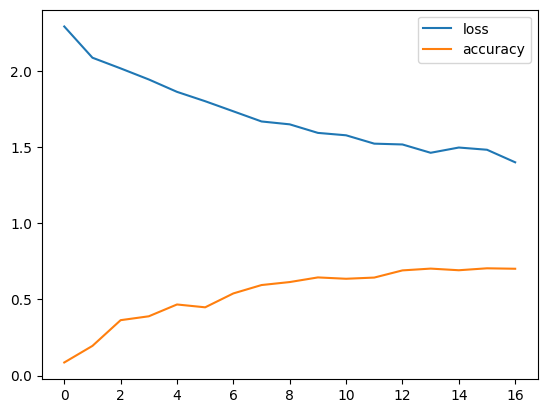

Accuracy: 0.7009803921568627


In [15]:
# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

print("Accuracy:",acc_history[-1])

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.005)